<a href="https://colab.research.google.com/github/ludawg44/jigsawlabs/blob/master/02May20_Coercing%20the%20Target.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coercing the Target

### Introduction

In this lesson, we'll walk through some of the techniques for coercing our target variable.  Let's start by loading up our data.

### Loading the Data

In [0]:
import requests

url = 'https://raw.githubusercontent.com/jigsawlabs-student/engineering-large-datasets/master/99-coerce-target/dtypes_listings.json'
response = requests.get(url)
dtypes = response.json()

In [0]:
import pandas as pd
url_csv = "https://raw.githubusercontent.com/jigsawlabs-student/engineering-large-datasets/master/99-coerce-target/listings_target.csv"
df = pd.read_csv(url_csv, dtype = dtypes, index_col = 0)

In [0]:
df.select_dtypes('object').shape

(22544, 0)

### Training our model

In [0]:
X = df.drop(columns = ['price', 'log_price'])
y = df['price']

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_validate, y_train, y_validate = train_test_split(X, y, random_state = 42)

In [0]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X_train, y_train).score(X_validate, y_validate)

0.11422160237232248

What we can see from this model is not such an excellent score.  Let's take a look at the distribution of our data.

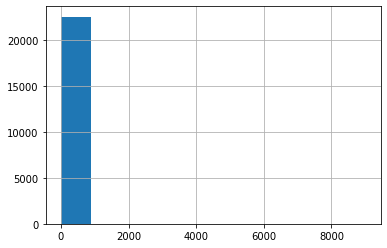

In [0]:
y.hist()

We can start by seeing that while most of our data appears close to zero, matplotlib is still showing us a wide range of values -- past 8000.  This is likely because of outliers.  Let's use describe to see some statistics about our target.

In [0]:
y.describe()

count    22544.000000
mean        67.167495
std        220.301658
min          1.000000
25%         30.000000
50%         45.000000
75%         70.000000
max       9000.000000
Name: price, dtype: float64

So we can see that while the average price is 67, the max price is at 9000.  This accounts for the distribution of the data we see above.  For example, if we limit our histogram to around 300, we see the following:

[(0, 300)]

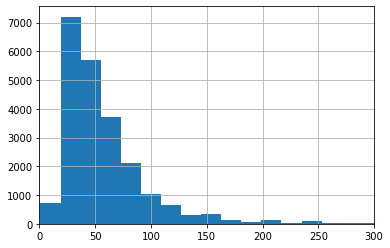

In [0]:
ax = y.hist(bins = 500)
ax.set(xlim = (0, 300))

So we can see that our data is pretty well skewed to the right.  And this still doesn't account for our top values in the 9000 range.

In [0]:
top_prices = y.value_counts().sort_index(ascending = False).iloc[:5]
top_prices

9000.0     1
8600.0     1
8000.0     1
6000.0    20
5000.0     2
Name: price, dtype: int64

### Why outliers are problematic

Outliers are particularly problematic for linear regression models.  To see why, let's look at a different linear model of our data -- one that uses just one of our features, `lastReviewElapsed`, the time since the last review, to look at price.

In [0]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train[['last_reviewElapsed']], y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
predictions = model.predict(X_validate[['last_reviewElapsed']])

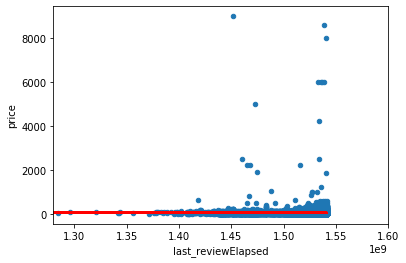

In [0]:
ax = df.dropna(subset = ['last_reviewElapsed']).plot.scatter(x = 'last_reviewElapsed', y = 'price')
ax.set(xlim = (1280000000, 1600000000))
ax.plot(X_validate['last_reviewElapsed'], predictions, color = 'red')

We can see that while the model does tend to draw a line through most of the data points, it does not do a good job at predicting outliers.  This is in part, because linear regression fits to the data **globally**.  In other words, there is only one line drawn through the data, and must use a single line to predict both the lower priced data means and the outliers -- even though these observations behave differently.

### Taking the log

There are a couple different ways to handle outliers.  One is simply to choose a different kind of machine learning algorithm which is better at predicting outliers -- for example tree-based models.  Another is to adjust our target variable.

One of the most common ways to handle outliers is to take a log of the data.  To see why this effective, let's first review what our distribution of prices currently looks like.

[Text(0, 0.5, 'count'), (0, 300), Text(0.5, 0, 'price')]

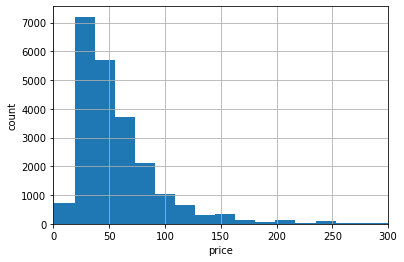

In [0]:
ax = y.hist(bins = 500)
ax.set(xlim = (0, 300), xlabel = 'price', ylabel = 'count')

And this a histogram of the log of price.

[Text(0, 0.5, 'count'), (0, 10), Text(0.5, 0, 'price')]

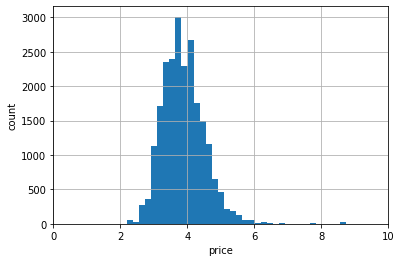

In [0]:
ax = df['log_price'].hist(bins = 50)
ax.set(xlim = (0, 10), xlabel = 'price', ylabel = 'count')

We can see that taking the log makes our distribution less skewed. 

Now let's see why this is the case.  Let's say we have prices of 60, 600, and 6000.

In [0]:
import numpy as np
prices =  np.array([6, 60, 600, 6000])

Taking the log of these values decreases our large numbers much more than it decreased our small numbers.  

In [0]:
np.log(prices)

So this tends to squeeze in our outliers.

Notice that our linear regression model can better fit to the data now that this data is less skewed. 

In [0]:
from sklearn.linear_model import LinearRegression

log_model = LinearRegression()

log_model.fit(X_train, np.log(y_train)).score(X_validate, np.log(y_validate))

0.569405590563142

Once we move to taking the log of the target variable, our interpretation of the linear model changes.  For example, assume we find that our model's coefficients look like the following, and we did not apply the log:

$price = 20*num\_rooms + 50*sq\_meters  + c$

If we had not taken the log of price, remember we interpret this as a one unit increase in the number of rooms leads to an increase in price of 20.  Once we move to the log however, we may get a different model, like so:

$log(price) = .3*num\_rooms + .2*sq\_meters  + c$

Here this is saying that a one unit increase in the number of rooms, leads to a 30 **percent increase** in the price.  An explanation as to why follows in the next section.

### Explaining the Interpretation of the Log

Once we move to taking the log of the target variable, our interpretation of the linear model changes.  Remember that normally we have a linear model of the following form:

$price = 3*num\_rooms + 2*sq\_meters  + c$

And that we interpret this as:

* For a one unit change in the number of rooms, price changes by 3.  
* And for a one unit change in the number of meters, price changes by 2. 

While we can see this intuitively, if we wanted to show this mathematically, we could do so by taking the derivative with respect to each variable.

* $\frac{\Delta price}{\Delta num\_rooms} = 3$ 

* $\frac{\Delta price}{\Delta sq\_meters} = 2$

Now let's see what happens when we apply the log transformation.  When we fit a model to the log of a target, we'll get an equation something like the following:

$log(price) = \theta_1*num\_rooms + \theta_2*sq\_meters + c$

Now let's try to interpret the impact that each coefficient has on price.  We can start by solving for our target, price.  So we do so by applying the exponent to each side.  This gives us the following.



$ price = e^{\theta_1*num\_rooms + \theta_2*sq\_meters + c} $

And so if we want to see how a unit change in the number of rooms affects our price, then again we take the derivative.  Now the derivative of $e^x$ equals $e^x$.  And the derivative of our formula:

$\frac{\Delta price}{\Delta num\_rooms} = \theta_{num\_rooms}*e^{\theta_1x_1 + \theta_2x_2 + x_3} $

> Notice that $e^{\theta_1x_1 + \theta_2x_2 + x_3} = y$, so applying substitution, we get:

$\frac{\Delta price}{\Delta num\_rooms} = \theta_1*y $

So in other words each coefficient now represents a percentage change in our target.  So for example, if $\theta_1 = .1$, then a one unit change in $x$ leads to a $.1y$ increase in $y$.  In other words, $y$ increases by 10 percent.

### Resources 

[David Dranove - Northwestern University](https://www.kellogg.northwestern.edu/faculty/dranove/htm/dranove/coursepages/mgmt469.htm)